# Deep Learning on Timeseries for the OMOP CDM with ehrdata
ehrdata offers a deep learning convenience map-style [pytorch dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), EHRDataset.
This is the input for pytorch's Dataloader, the canonical data loading structure for deep learning models in pytorch.

For more information on the OMOP Common Data Model (CDM), see the notebook on the [OMOP CDM](./omop_tables_tutorial.ipynb).


## Introduction

Disclaimer: the example usecase is for demonstration purposes only.
The data preprocessing, the task definition, and the model setup are meant to be introductory and as such lack the complexity required for proper inference.

##  Predict in-hospital mortality of ICU patients

We consider the task of predicting the in-hospital mortality of ICU patients, using public [MIMIC-IV demo dataset in the OMOP Common Data Model](https://physionet.org/content/mimic-iv-demo-omop/0.9/).

Dataset:<br>
Kallfelz, M., Tsvetkova, A., Pollard, T., Kwong, M., Lipori, G., Huser, V., Osborn, J., Hao, S., & Williams, A. (2021). MIMIC-IV demo data in the OMOP Common Data Model (version 0.9). PhysioNet. https://doi.org/10.13026/p1f5-7x35.

### Imports
We start with the required imports

In [1]:
import torch
import duckdb
import numpy as np
from torch.utils.data import DataLoader

import ehrdata as ed
import ehrapy as ep

### Setup the database
We use the plug-and-play ehrdata dataset, and duckdb as our RDMS.
#### Setup a local database connection

In [2]:
con = duckdb.connect(":memory:")

#### Download the data, and load it into the database
Convenience dataset available from ehrdata.

In [ ]:
ed.dt.mimic_iv_omop(backend_handle=con)

#### Define the Cohort
We start off by considering only patients with a `visit_occurrence` in ICU (`visit_concept_id` in `visit_detail` for ICU: In this dataset, we choose the OMOP Concept IDs
- 4305366 for Surgical ICU
- 40481392 for Medical ICU
- 32037 for Intensive Care
- 763903 for Trauma ICU
- 4149943 for Cardiac ICU

If a person had multiple such ICU stays, we select the first.

There are better ways than to delete rows in `visit_occurrence` which do not satisfy our cohort definition from our database, for the toy example this is the fastest.

In [ ]:
con.execute("""
    WITH RankedVisits AS (
        SELECT
            v.*,
            vd.*,
            ROW_NUMBER() OVER (PARTITION BY v.person_id ORDER BY v.visit_start_date) AS rn
        FROM visit_occurrence v
        JOIN visit_detail vd USING (visit_occurrence_id)
        WHERE vd.visit_detail_concept_id IN (4305366, 40481392, 32037, 763903, 4149943)
    ),
    first_icu_visit_occurrence_id AS (
        SELECT visit_occurrence_id
        FROM RankedVisits
        WHERE rn = 1
    )
    DELETE FROM visit_occurrence
    WHERE visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM first_icu_visit_occurrence_id)
""")

#### Define the variables of interest and the time windows.

Here, we decide for the following:
- We have for each person (n=100) one in-hospital stay; take the start of this hospital stay as the starting point (t=0) for each patient.
- We consider time-intervals of 1h, for 24h; that is, the first day after ICU admission. If for a patient less recorded data is available, the missing data is padded.
- We consider the data from the `measurements` table; we consider the numeric `value_as_number` values.


We now set up the persons to be considered, together with their observation start and endtimes, retrieved from the `visit_occurrence` table.

In [5]:
edata = ed.io.omop.setup_obs(
    backend_handle=con,
    observation_table="person_visit_occurrence",
)

In the next step, we retrieve all `value_as_number` entries from the `measurements` table:

In [ ]:
edata = ed.io.omop.setup_variables(
    edata=edata,
    backend_handle=con,
    data_tables=["measurement"],
    data_field_to_keep=["value_as_number"],
    interval_length_number=1,
    interval_length_unit="h",
    num_intervals=24,
    concept_ids="all",
    aggregation_strategy="last",
    instantiate_tensor=False,
)

NOTE: this could/should become an ehrdata API call.

We drop features which are not measured in at least 10 patients 1x.

In [ ]:
# delete all rows for which data_table_concept_id is NOT NULL in at least 10 different patient_id s
con.execute("""
    WITH concept_ids_to_delete AS (

        SELECT
            data_table_concept_id
        FROM long_person_timestamp_feature_value_measurement
        WHERE value_as_number IS NOT NULL
        GROUP BY data_table_concept_id
        HAVING COUNT(DISTINCT person_id) <= 10

        UNION

        SELECT
            data_table_concept_id
        FROM long_person_timestamp_feature_value_measurement
        GROUP BY data_table_concept_id
        HAVING COUNT(value_as_number) = 0
    )

    DELETE FROM long_person_timestamp_feature_value_measurement
    WHERE data_table_concept_id IN (
        SELECT data_table_concept_id FROM concept_ids_to_delete
    );
""")

NOTE: this could/should become an ehrdata API call.

For model simpliclity, we conduct forward filling of the variables:

In [ ]:
con.execute("""
WITH filled_measurements AS (
    SELECT
        person_id,
        interval_step,
        data_table_concept_id,
        COALESCE(value_as_number,
                 LAST_VALUE(value_as_number IGNORE NULLS)
                 OVER (PARTITION BY person_id, data_table_concept_id
                       ORDER BY interval_step
                       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
        ) AS filled_value
    FROM long_person_timestamp_feature_value_measurement
)
UPDATE long_person_timestamp_feature_value_measurement
SET value_as_number = fm.filled_value
FROM filled_measurements as fm
WHERE long_person_timestamp_feature_value_measurement.person_id = fm.person_id
AND long_person_timestamp_feature_value_measurement.interval_step = fm.interval_step
AND long_person_timestamp_feature_value_measurement.data_table_concept_id = fm.data_table_concept_id;
""")

And for all values not captured in forward fill, we impute the missing value for person x, feature f, time step t as the mean of all other persons feature f at timestep t.

In [ ]:
con.execute("""
WITH feature_means AS (
    SELECT
        interval_step,
        data_table_concept_id,
        AVG(value_as_number) AS mean_value
    FROM long_person_timestamp_feature_value_measurement
    WHERE value_as_number IS NOT NULL
    GROUP BY interval_step, data_table_concept_id
),
filled_values AS (
    SELECT
        lptfv.person_id,
        lptfv.interval_step,
        lptfv.data_table_concept_id,
        COALESCE(lptfv.value_as_number, fm.mean_value) AS filled_value
    FROM long_person_timestamp_feature_value_measurement lptfv
    LEFT JOIN feature_means fm
    ON lptfv.interval_step = fm.interval_step
       AND lptfv.data_table_concept_id = fm.data_table_concept_id
)
UPDATE long_person_timestamp_feature_value_measurement
SET value_as_number = fm.filled_value
FROM filled_values as fm
WHERE long_person_timestamp_feature_value_measurement.person_id = fm.person_id
AND long_person_timestamp_feature_value_measurement.interval_step = fm.interval_step
AND long_person_timestamp_feature_value_measurement.data_table_concept_id = fm.data_table_concept_id;
""")

### Deep Learning Model
#### Data Loading

The tensor of shape n_obs x n_vars x num_intervals has been prepared in the RDBMS.
We can now create an `EHRDataset`, which is a subclass of pytorch's Dataset, and will stream the data for a deep learning model from the database.

In [10]:
dataset = ed.integrations.torch.OMOPEHRDataset(con, edata, data_tables=["measurement"], idxs=None)

The `EHRDataset`, as subclass of pytorch's `Dataset`, can be used right away for creating a pytorch `Dataloader`.

In [11]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

#### Model definition
We create a simple model for time series based on a Recurrent Neural Network in pytorch.
More advanced models interoperable with ehrdata are showcased in [Time Series Analysis with ehrdata and PyPOTS](./tutorial_time_series_with_pypots.ipynb). However, PyPOTS does not support a pytorch Dataloader as input.

In [12]:
from torch import nn
import torch.nn.functional as F


class RNN_Model(nn.Module):
    """RNN Model."""

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def _prepare_batch(self, batch):
        x, target = batch
        return torch.transpose(x, 2, 1), target.flatten().to(torch.long)

    def forward(self, x):
        """Forward method."""
        # x: (batch_size, seq_len, input_size)
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        # out: (batch_size, num_classes)
        logits = self.fc(out)
        return out, logits

    def training_step(self, batch):
        """Training step."""
        x, target = self._prepare_batch(batch)
        _out, logits = self(x)
        loss = F.cross_entropy(logits, target)
        return loss

    def fit(self, loader, epochs=10):
        """Fit method."""
        self.train_loss = []
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        for epoch in range(epochs):
            batch_loss = []
            for batch in loader:
                optimizer.zero_grad()
                loss = self.training_step(batch)
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())

            self.train_loss.append(np.mean(np.array(batch_loss)))
            print(f"Epoch {epoch}, Loss: {np.mean(np.array(batch_loss))}")

    def predict(self, loader, *, soft=True):
        """Predict method."""
        predictions = []
        with torch.no_grad():
            for batch in loader:
                x, _target = self._prepare_batch(batch)
                _, classification_logits = self(x)
                predicted = torch.softmax(classification_logits, 1) if soft else torch.max(classification_logits, 1)
                predictions.append(predicted)
        return torch.cat(predictions)

    def represent(self, loader):
        """Represent method."""
        representations = []
        with torch.no_grad():
            for batch in loader:
                x, _target = self._prepare_batch(batch)
                output, _ = self(x)
                representations.append(output)
        return torch.cat(representations)

#### Model training

In [13]:
model = RNN_Model(
    input_size=129,
    hidden_size=16,
    num_layers=1,
    num_classes=2,
)
model.fit(loader, epochs=5)

Epoch 0, Loss: 0.373914515376091
Epoch 1, Loss: 0.3558880844712257
Epoch 2, Loss: 0.3530735236406326
Epoch 3, Loss: 0.3501975649595261
Epoch 4, Loss: 0.3482479679584503


#### Model prediction
Classification could look like this

In [ ]:
model.predict(loader)

#### Model representation
Futher, could illustrate patient representation:

In [15]:
edata.obsm["last_step_representation"] = np.array(model.represent(loader))

In [16]:
# add unused mock data
edata.X = np.zeros((edata.n_obs, edata.n_vars))

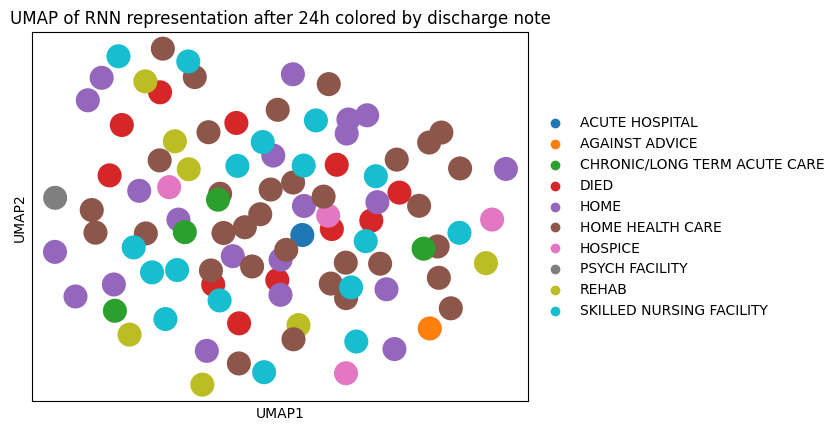

In [17]:
ep.pp.neighbors(edata, use_rep="last_step_representation")
ep.tl.umap(edata)
ep.pl.umap(
    edata, color="discharge_to_source_value", title="UMAP of RNN representation after 24h colored by discharge note"
)